# **AUTOMATED STOCK TRADING USING REINFORCEMENT LEARNING**

In [ ]:
# Importing the Neccessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
!pip install yfinance --upgrade --no-cache-dir

from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 996.9 kB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.33
    Uninstalling yfinance-0.2.33:
      Successfully uninstalled yfinance-0.2.33


# -  **We are Using the Yahoo Finance Library to fetch Our dataset**


In [ ]:
# Importing the Stock data

yf.pdr_override()
df_full = pdr.get_data_yahoo("INFY", start="2018-01-01").reset_index()
df_full.to_csv("INFY.csv",index=False)
df_full.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,8.135,8.195,8.115,8.145,6.944895,12298200
1,2018-01-03,8.120,8.135,8.050,8.075,6.885209,10250800
2,2018-01-04,8.100,8.100,8.010,8.025,6.842575,16272000
3,2018-01-05,8.085,8.190,8.075,8.175,6.970474,9813600
4,2018-01-08,8.190,8.260,8.170,8.240,7.025897,11198200


In [ ]:
# Defining the Functions inside a Class

df = df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):

        # agent attributes
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size


        # Q-learning Parameters

        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5 # exploration-exploitation factor
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999


        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()

        # Neural Network Configurations:

        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu) # single Hidden Layer of 256 units
        self.logits = tf.layers.dense(feed, self.action_size)

        # Loss And Optimization

        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))  # Mean Squared Error (L2 Loss)
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(self.cost) # Optimizer  = Gradient Descent

        # Global variables initialization ( Start Session )
        self.sess.run(tf.global_variables_initializer())


    # "act" function  = To make a move
    def act(self, state):
            if random.random() <= self.epsilon:   # For Exploration
                return random.randrange(self.action_size)

            return np.argmax(self.sess.run(self.logits, feed_dict = {self.X: state})[0]) # For Exploitation



    # Gives the current state of the agent in our envirionment
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

  # it replays the experiiences and the updates the Q-value table
    def replay(self, batch_size):

        # creates a Mini batch of same size as of last batch
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])

        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))

        # extracts the states and computes The New Q-vlaues form the neural network
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})

        # Q-value Table updation
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward

            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target

        # Cost Computation
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y})

        # Gradual Decay of Exploring rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return cost

    # Simulates the BUY action

    def buy(self, initial_money):

        # Initial Specifications and Money
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)



        for t in range(0, len(self.trend) - 1, self.skip):  # acts as time

            action = self.act(state) # chooses an action on current state
            next_state = self.get_state(t + 1) # reaches this state

            # IF BUY
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)

                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            # IF SELL
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0

                print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'% (t, close[t], invest, initial_money))

            state = next_state

        # Financials after current state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
      for i in range(iterations):
          total_profit = 0
          inventory = []
          state = self.get_state(0)
          starting_money = initial_money
          for t in range(0, len(self.trend) - 1, self.skip):
              action = self.act(state)
              next_state = self.get_state(t + 1)
              if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                  inventory.append(self.trend[t])
                  starting_money -= self.trend[t]
              elif action == 2 and len(inventory) > 0:
                  bought_price = inventory.pop(0)
                  total_profit += self.trend[t] - bought_price
                  starting_money += self.trend[t]
              invest = ((starting_money - initial_money) / initial_money)
              self.memory.append((state, action, invest,
                                  next_state, starting_money < initial_money))
              state = next_state
              batch_size = min(self.batch_size, len(self.memory))
              cost = self.replay(batch_size)
          if (i+1) % checkpoint == 0:
              print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                starting_money))


In [ ]:
close = df.Close.values.tolist()
initial_money = 100000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

<ipython-input-11-1ac386dbf999>:35: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu) # single Hidden Layer of 256 units
<ipython-input-11-1ac386dbf999>:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: 1939.674998.3, cost: 0.012800, total money: 94933.655005
epoch: 20, total rewards: 1213.470003.3, cost: 0.010624, total money: 95845.600007
epoch: 30, total rewards: 504.489999.3, cost: 0.008349, total money: 96902.270004
epoch: 40, total rewards: 346.874992.3, cost: 0.006864, total money: 97544.614995
epoch: 50, total rewards: 262.600000.3, cost: 0.006006, total money: 97721.380007
epoch: 60, total rewards: 122.265002.3, cost: 0.005160, total money: 98097.115008
epoch: 70, total rewards: 12.015000.3, cost: 0.004489, total money: 98412.245004
epoch: 80, total rewards: -9.159999.3, cost: 0.003998, total money: 98595.190005
epoch: 90, total rewards: 67.834990.3, cost: 0.003130, total money: 98696.804995
epoch: 100, total rewards: 84.499995.3, cost: 0.003331, total money: 98744.039999
epoch: 110, total rewards: 72.375000.3, cost: 0.003015, total money: 98922.235003
epoch: 120, total rewards: 14.324997.3, cost: 0.002825, total money: 98916.255001
epoch: 130, total

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 8.025000, total balance 99991.975000
day 10: buy 1 unit at price 9.060000, total balance 99982.915000
day 13, sell 1 unit at price 9.145000, investment 13.956397 %, total balance 99992.060000,
day 14: buy 1 unit at price 9.225000, total balance 99982.835000
day 15, sell 1 unit at price 9.230000, investment 1.876370 %, total balance 99992.065000,
day 16: buy 1 unit at price 9.225000, total balance 99982.839999
day 17: buy 1 unit at price 9.250000, total balance 99973.589999
day 18: buy 1 unit at price 9.275000, total balance 99964.315000
day 19: buy 1 unit at price 9.125000, total balance 99955.190000
day 20, sell 1 unit at price 9.005000, investment -2.384827 %, total balance 99964.195000,
day 21, sell 1 unit at price 8.965000, investment -2.818431 %, total balance 99973.160000,
day 22: buy 1 unit at price 8.875000, total balance 99964.285000
day 23, sell 1 unit at price 8.685000, investment -6.108104 %, total balance 99972.970000,
day 24, sell 1 unit at pric

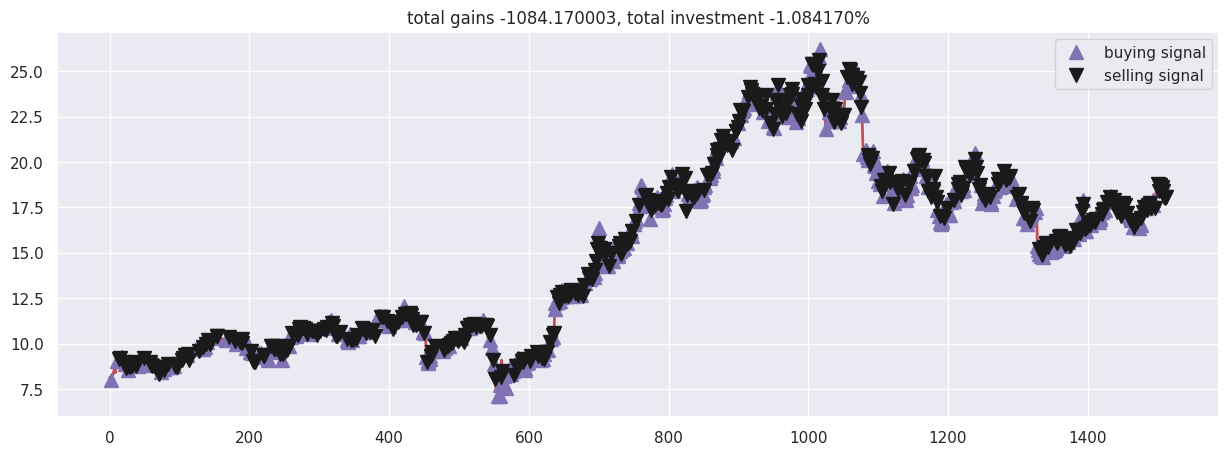

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()